In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request

data_path = Path('data/appml-assignment1-dataset-v2.pkl')
correct_tf_path = Path('data/correct.tfrecord')
if not data_path.is_file() or not correct_tf_path.is_file():
  Path('data').mkdir(parents=True, exist_ok=True)
  url = "https://github.com/SanthoshV14/app-ml-hw-1/blob/main/data/appml-assignment1-dataset-v2.pkl?raw=true"
  urllib.request.urlretrieve(url, filename=data_path)
  url = 'https://github.com/SanthoshV14/app-ml-hw-1/blob/main/data/correct.tfrecord?raw=true'
  urllib.request.urlretrieve(url, filename=correct_tf_path)

pkl = pd.read_pickle("./data/appml-assignment1-dataset-v2.pkl")
X = pkl['X']
y = pkl['y']

In [14]:
# Fractional Change
change = (X['CAD-high'] - X['CAD-close']) / X['CAD-close']
bins = np.linspace(-0.001, 0.001, 21)
target = np.digitize(change, bins=bins)

date = pd.to_datetime(X['date'])

# Day of the Week
weekday = date.dt.day_of_week.astype('category')

# Hour of the Day
hour = date.dt.hour.astype('category')

# Month of the Year
month = date.dt.month.astype('category') 

# Tikcers
tickers = X.iloc[:, 1:]

In [15]:
# Feature Creation
from tensorflow.train import FloatList,Int64List, Feature,Features,Example

with tf.io.TFRecordWriter('dataset.tfrecord') as f:
    for index in range(len(X)):
        feature={
            'tickers':Feature(float_list=FloatList(value=tickers.values[index])),
            'weekday':Feature(int64_list=Int64List(value=[weekday.values[index]])),
            'month':Feature(int64_list=Int64List(value=[month.values[index]])),
            'hour':Feature(int64_list=Int64List(value=[hour.values[index]])),
            'target':Feature(int64_list=Int64List(value=[target[index]])),
        }
        myExamp=Example(features=Features(feature=feature))
        f.write(myExamp.SerializeToString())

In [16]:
class myImputer(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
  def __init__(self, **kwargs):
    super().__init__( **kwargs)
  
  def build(self,batch_input_shape):
    self.imps=self.add_weight(name='imps',shape=(batch_input_shape[-1]),
    initializer="zeros",trainable=False)
    super().build(batch_input_shape)
  
  def call(self, X):
    return tf.where(tf.math.is_nan(X),self.imps,X)
  
  def adapt(self, dataset):
    self.build(dataset.element_spec.shape)
    sumOfNonNaNs=dataset.map(
        lambda z: tf.where(tf.math.is_nan(z),
                           tf.zeros_like(z),z)).reduce(
                               tf.zeros_like(self.imps),
                               lambda x,y: x+tf.reduce_sum(y,axis=0))
    
    numberOfNonNaNs=dataset.map(
        lambda z: tf.where(tf.math.is_nan(z),
                           tf.zeros_like(z),tf.ones_like(z))).reduce(
                               tf.zeros_like(self.imps),
                               lambda x,y: x+tf.reduce_sum(y,axis=0))
    self.imps.assign(tf.math.divide(sumOfNonNaNs,numberOfNonNaNs))
  
  def computer_output_shape(self,batch_input_shape):
    return batch_input_shape

In [17]:
# Define the feature description
feature_description = {
    'tickers': tf.io.FixedLenFeature([tickers.shape[1]], tf.float32, np.zeros(tickers.shape[1])),
    'weekday': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'month': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'hour': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'target': tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

# Parse the serialized examples into a dictionary of tensors
def parse_example(serialized_example):
    example = tf.io.parse_example(serialized_example, feature_description)
    features = {k: v for k, v in example.items() if k != 'target'}
    target = example['target']
    return features, target

In [18]:
# Split the dataset into training, validation, and testing datasets
raw_dataset = tf.data.TFRecordDataset(['dataset.tfrecord'])
datLen = raw_dataset.reduce(0,lambda x,y: x+1)
n_valid = int(datLen.numpy()*.1)
n_test = int(datLen.numpy()*.1)
n_train = datLen.numpy()-n_valid-n_test
train = raw_dataset.take(n_train).batch(2048).map(
    parse_example,num_parallel_calls=8).cache()

test = raw_dataset.skip(n_train).take(n_test).batch(2048).map(
    parse_example,num_parallel_calls=8).cache()

valid = raw_dataset.skip(n_train+n_test).take(n_valid).batch(2048).map(
    parse_example,num_parallel_calls=8).cache()

# Define input layers
inputDict = {
    'tickers': tf.keras.Input(shape=(188,), dtype=tf.float32),
    'weekday': tf.keras.Input(shape=(), dtype=tf.int64),
    'month': tf.keras.Input(shape=(), dtype=tf.int64),
    'hour': tf.keras.Input(shape=(), dtype=tf.int64)
}

# Create an instance of the Imputer layer
imputer = myImputer()
imputer.adapt(train.map(lambda x,y: x['tickers']))
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train.map(lambda x,y: imputer(x['tickers'])))

In [19]:
weekday_nTokens = 6
weekday_catEncoder=tf.keras.layers.IntegerLookup(max_tokens=weekday_nTokens,num_oov_indices=0)
weekday_catEncoder.adapt(train.map(lambda x,y:x['weekday']))
weekday_catInts=weekday_catEncoder(inputDict['weekday'])

month_nTokens = 12
month_catEncoder=tf.keras.layers.IntegerLookup(max_tokens=month_nTokens,num_oov_indices=0)
month_catEncoder.adapt(train.map(lambda x,y:x['month']))
month_catInts=month_catEncoder(inputDict['month'])

hour_nTokens = 24
hour_catEncoder=tf.keras.layers.IntegerLookup(max_tokens=hour_nTokens,num_oov_indices=0)
hour_catEncoder.adapt(train.map(lambda x,y:x['hour']))
hour_catInts=hour_catEncoder(inputDict['hour'])

weekday_embedding = tf.keras.layers.Embedding(weekday_nTokens, 2)(weekday_catInts)
month_embedding = tf.keras.layers.Embedding(month_nTokens, 2)(month_catInts)
hour_embedding = tf.keras.layers.Embedding(hour_nTokens, 2)(hour_catInts)

# Flatten the embedding outputs
weekday_embedding = tf.keras.layers.Flatten()(weekday_embedding)
month_embedding = tf.keras.layers.Flatten()(month_embedding)
hour_embedding = tf.keras.layers.Flatten()(hour_embedding)

In [20]:
for el in tf.data.TFRecordDataset(['dataset.tfrecord']).batch(32).map(parse_example).take(1):
  print(el[1])

for el in tf.data.TFRecordDataset(['data/correct.tfrecord']).batch(32).map(parse_example).take(1):
  print(el[1])

tf.Tensor(
[13 11 15 16 16 21 19 19 18 14 13 14 21 15 15 21 12 18 11 21 11 15 14 18
 15 16 16 21 18 21 14 18], shape=(32,), dtype=int64)
tf.Tensor(
[13 14 14 22 14 22 14 21 12 16 15 14 12 18 13 22 12 16 12 14 13 13 13 14
 17 11 17 22 22 22 18 15], shape=(32,), dtype=int64)


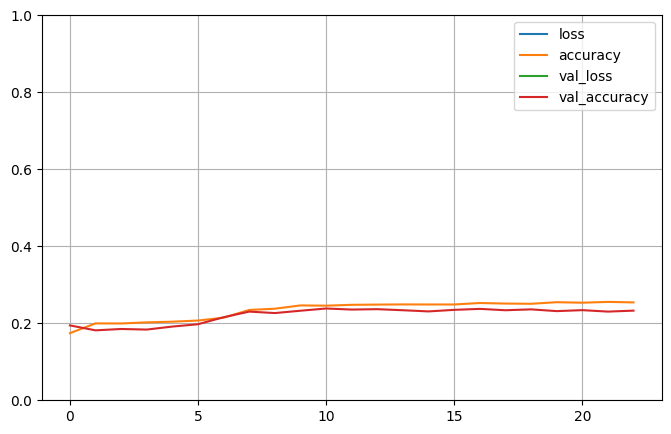

In [21]:
# Concatenate all the inputs
preproced = tf.concat([normalizer(imputer(inputDict['tickers'])), weekday_embedding, month_embedding, hour_embedding], axis=-1)

restMod = tf.keras.Sequential([
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),

    tf.keras.layers.Dense(22, activation='softmax')
    ])

decs = restMod(preproced)
whole_model = tf.keras.Model(inputs=inputDict, outputs=decs)
whole_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# whole_model.summary()

# Defining callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('mySavedModel', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

# Training the model
history = whole_model.fit(train, epochs=200, verbose=0, validation_data=valid, callbacks=[early_stopping_cb, checkpoint_cb])


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [23]:
whole_model.evaluate(test)

2/2 [==============================] - 1s 160ms/step - loss: 2.1793 - accuracy: 0.2381


[2.1793372631073, 0.23814329504966736]